In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

In [34]:
##### grid details
Lx = 1
Ly = 1

NX = 14;  nx = NX - 2
NY = 16;  ny = NY - 2

dx = Lx / (nx+1)   ## we dont consider ghost points here
dy = Ly / (ny+1)

x = np.linspace(dx, Lx - dx, nx)
y = np.linspace(dy , Ly - dy, ny)

xx, yy = np.meshgrid(x, y)

##### initialise stream-function 
psi_0 = np.zeros((NY, NX)) 

##### initialise vorticity field
omega = np.zeros((NY, NX))
omega[1:-1, 1:-1] = -2 * (np.pi**2) * np.sin(np.pi*xx) * np.sin(np.pi*yy)

##### the exact solution, for testing 
psi_ext = np.zeros((NY, NX))
psi_ext[1:-1, 1:-1] = np.sin(np.pi*xx) * np.sin(np.pi*yy) 

# fig1, ax2 = plt.subplots(constrained_layout=True)
# CS = ax2.contourf(xx, yy, psi_ext[1:-1, 1:-1], 50)
# cbar = fig1.colorbar(CS)
# ax2.set_aspect('equal')



In [ ]:
def PoissonSol_Jacobi(dx, dy, omega, psi_0, tol):
    
    psi = psi_0.copy()
    psi_n = np.zeros_like(psi)
    err = np.sqrt(np.sum((psi-psi_ext)**2))
    niter = 0

    ### for convergence test plotting
    err_test = []
    # fig, ax = plt.subplots()
    # ax.plot(N_conv_test, err_test)
    # plt.show()

    while err > tol:
        niter += 1
        psi_n = psi.copy()

        ## update (n+t)-th iteration for psi
        # psi[1:-1, 1:-1] = ((dy**2)*(psi_n[1:-1, 2:] + psi_n[1:-1, :-2]) + (dx**2)*(psi_n[2:, 1:-1] + psi_n[:-2, 1:-1])
        #                     - dx**2 * dy**2 * omega[1:-1, 1:-1]) / (2*(dx**2+dy**2))

        psi[1:-1, 1:-1] = (psi_n[1:-1, 2:] + psi_n[1:-1, :-2] + (dx**2/dy**2)*psi_n[2:,1:-1] + 
                            (dx**2/dy**2)*psi_n[:-2,1:-1] - dx**2 * omega[1:-1, 1:-1]) / (2*(1+dx**2/dy**2))
        


        ## exam error in the current iteration
        err = np.sqrt(np.sum((psi-psi_ext)**2))
        err_test.append(err)
        
        # ## update convergence test plot
        # plt.cla()
        # ax.plot(N_conv_test, err_test)
            

    return psi, niter, err_test



In [ ]:
#### Gauss-Seidel method

def PoissonSol_GaussSeidel(dx, dy, omega, psi_0,  tol):

    psi = psi_0.copy()
    niter = 0
    err = 10
    RSE = []

    while err > tol :

        for xi in range(1, NX-1):
            for yj in range(1, NY-1):
                # psi_n = psi.copy()
                # psi[yj, xi] = ((dy**2)*(psi[yj, (xi-1)] + psi_n[yj, (xi+1)]) + (dx**2)*(psi[(yj-1), xi] + psi_n[(yj+1), xi])
                #                 - dx**2 * dy**2 * omega[yj, xi]) / (2*(dx**2+dy**2))
                psi[yj, xi] = ((dy**2)*(psi[yj, (xi-1)] + psi[yj, (xi+1)]) + (dx**2)*(psi[(yj-1), xi] + psi[(yj+1), xi])
                                - dx**2 * dy**2 * omega[yj, xi]) / (2*(dx**2+dy**2))
        
        niter += 1
        err = np.sqrt(np.sum((psi-psi_ext)**2))
        RSE.append(err)

    return psi, niter, RSE


In [ ]:
#### Gauss-Seidel method

def PoissonSol_GaussSeidel(dx, dy, omega, psi_0,  tol):

    psi = psi_0.copy()
    niter = 0
    err = 10
    RSE = []

    while err > tol :

        for xi in range(1, NX-1):
            for yj in range(1, NY-1):
                # psi_n = psi.copy()
                # psi[yj, xi] = ((dy**2)*(psi[yj, (xi-1)] + psi_n[yj, (xi+1)]) + (dx**2)*(psi[(yj-1), xi] + psi_n[(yj+1), xi])
                #                 - dx**2 * dy**2 * omega[yj, xi]) / (2*(dx**2+dy**2))
                psi[yj, xi] = ((dy**2)*(psi[yj, (xi-1)] + psi[yj, (xi+1)]) + (dx**2)*(psi[(yj-1), xi] + psi[(yj+1), xi])
                                - dx**2 * dy**2 * omega[yj, xi]) / (2*(dx**2+dy**2))
        
        niter += 1
        err = np.sqrt(np.sum((psi-psi_ext)**2))
        RSE.append(err)

    return psi, niter, RSE

In [ ]:
res_J, N_J, Err_test_J = PoissonSol_Jacobi(dx, dy, omega, psi_0, tol=0.01)
err_exp_J = [Err_test_J[0]*(np.cos(np.pi/(nx+1)))**k for k in range(N_J)]

res_GS, N_GS, Err_test_GS = PoissonSol_GaussSeidel(dx, dy, omega, psi_0, tol=0.01)

plt.plot(np.arange(N_J), Err_test_J, '-b', label='iteration errors Jacobi')
plt.plot(np.arange(N_J), err_exp_J, '-r', label='expected error')
plt.plot(np.arange(N_GS), Err_test_GS, label='iteration errors GS')
plt.legend(loc="upper right")


In [9]:
#### SOR method

def PoissonSol_SOR(dx, dy, omega, psi_0, param, tol):

    psi = psi_0.copy()
    niter = 0
    err = 10
    RSE = []

    while err > tol :

        for xi in range(1, NX-1):
            for yj in range(1, NY-1):
                psi_GS_loc = ((dy**2)*(psi[yj, (xi-1)] + psi[yj, (xi+1)]) + (dx**2)*(psi[(yj-1), xi] + psi[(yj+1), xi])
                                - dx**2 * dy**2 * omega[yj, xi]) / (2*(dx**2+dy**2))
                psi[yj, xi] = param * psi_GS_loc + (1 - param) * psi[yj, xi]
        
        niter += 1
        err = np.sqrt(np.sum((psi-psi_ext)**2))
        RSE.append(err)

    return psi, niter, RSE


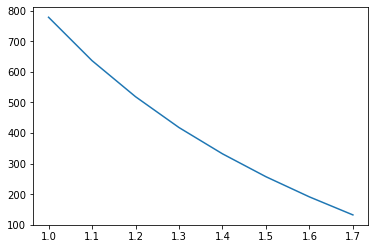

In [16]:
### SOR parameter test

params = np.linspace(1, 1.7, 8)
res = [PoissonSol_SOR(dx, dy, omega, psi_0, param_test, tol=0.01) for param_test in params]
Ns = [res[i][1] for i in range(len(res))]
plt.plot(params, Ns)

In [36]:
import sympy as smp
from sympy import symbols, lambdify
#### create an expression for convergence rate rho as a function of params. 
param_sym = symbols('w')
mu_sym = symbols('\mu')
rho_expr = (param_sym*mu_sym + smp.sqrt(param_sym**2 * mu_sym**2 - 4*(param_sym-1)))**2 / 4
rho = lambdify((param_sym, mu_sym), rho_expr, 'numpy')

#### param mu is determined by grid numbers 
mu = np.cos(np.pi/(nx+1))
param_opt = 2 / (1+np.sin(np.pi/(nx+1)))
rho(1, mu)

0.9427280128266049